# Introduction 

In this notebook, we will analyze a dataset containing the hourly and daily count of rental bikes between years 2011 and 2012 in the Washington D.C Capital bikeshare system with corresponding weather and seasonal information. Each row in the dataset represents the number of bike rentals for a single hour of a single day.

We will try to predict the number of bike rentals given a set of relevant features using the following models:
1. Linear Regression
2. Decision Tree
3. Random Forest
4. Gradient Boosted Regression Tree

We will also use grid search to evaluate the performance of models using several different combinations of hyperparameters.

Information about the dataset can be found @ https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [69]:
#load the required libraries and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Render plots inline
%matplotlib inline

In [70]:
#load the csv file containing the data into a dataframe
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head() #view the first 5 rows

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Data Exploration

In [71]:
#check if there are any null values in the dataset
bike_rentals.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

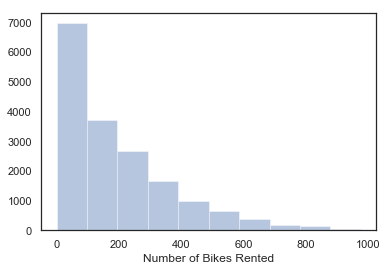

In [72]:
#Use Seaborn to plot a histogram of the number of bikes rented
sns.distplot(bike_rentals['cnt'], bins = 10, axlabel = 'Number of Bikes Rented', kde = False)

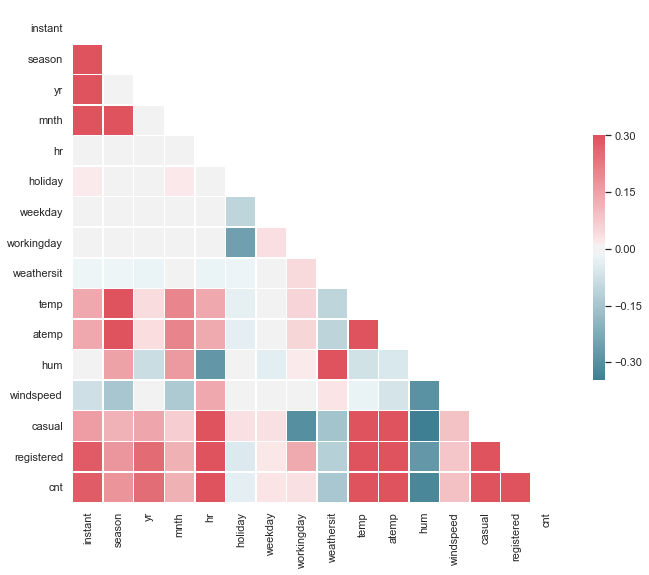

In [73]:
corrs = bike_rentals.corr() #compute the correlations between all the columns

#Following code is to plot a diagonal pairwise correlation matrix. Taken from https://seaborn.pydata.org/examples/many_pairwise_correlations.html 
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrs, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [74]:
#view the absolute value of the correlations of all the features with the target column ('cnt')
print(corrs['cnt'].abs().sort_values(ascending = False))

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64


# Feature Engineering

The only feature engineering we will do on this dataset will be to transform the 'hr' column by mapping each hour of the day to a particular value in the range of 1 to 4

In [75]:
#create a function to perform the mapping
def assign_label(hr):
    if hr <12 and hr >= 6:
        return 1
    elif hr <18 and hr >= 12:
        return 2
    elif hr <24 and hr >=18:
        return 3
    elif hr < 6 and hr >= 0:
        return 4

#apply the above function to the 'hr' column
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [76]:
#drop columns that add not value to our analysis such as 'registered', 'casual', and 'dteday'. 
#The columns 'registered' and 'casual' correspond to the type of rider and are irrelevant to us while 'dteday' contains the date of rentals which is not required because we already have the month, year, and whether it is a weekday, weekend, or a working day
bike_rentals_modified = bike_rentals.drop(columns = ['registered', 'casual', 'dteday', 'cnt'], axis = 1)

# Train and evaluate the learning models

In [77]:
#split the dataframe into training and test sets
from sklearn.model_selection import train_test_split

train,test = train_test_split(bike_rentals, test_size = 0.2, random_state = 42)

#separate the labels for training and test sets
labels_train = train['cnt']
labels_test = test['cnt']

#drop the columns we don't need as features in the training and test sets
train = train.drop(columns = ['registered', 'casual', 'dteday', 'cnt'], axis = 1)
test = test.drop(columns = ['registered', 'casual', 'dteday', 'cnt'], axis = 1)

## Linear Regression

In [78]:
#perform linear regression with a 10-fold cross validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
scores = cross_val_score(lr, bike_rentals_modified, bike_rentals['cnt'], scoring = 'neg_mean_squared_error', cv = 10)
lr_rmse_scores = np.sqrt(-scores)

In [79]:
#compute the average of the cross validation scores(root mean squared errors)
mean_lr_rmse = np.mean(lr_rmse_scores)
print(mean_lr_rmse)

130.94460025040786


So, we have achieved an average rmse of 131 through Linear Regression. Let's see if we can do better with other models.

## Decision Tree

In [80]:
#Lets train a decision tree model with default parameters and see if we can do better that Linear Regression

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

tree_reg = DecisionTreeRegressor()
tree_reg.fit(train,labels_train)
predictions = tree_reg.predict(train)
rmse_train = mean_squared_error(labels_train, predictions)**0.5
predictions = tree_reg.predict(test)
rmse_test = mean_squared_error(labels_test, predictions)**0.5

In [81]:
print("RMSE Train: ", rmse_train, "RMSE Test: ", rmse_test)

RMSE Train:  0.0 RMSE Test:  58.089453754656574


The decision tree has fit the training set perfectly but has an RMSE in the high 50s on the test set implying that it has overfit the training set. Decision trees are prone to overfitting and this is why ensemble learning models such as Random Forests do better. Nonetheless, the decision tree model has outperformed the Linear Regression model.

## Random Forest

In [82]:
#Lets train a random forest model with default parameters and see if we can do better than Linear Regression and Decision Tree
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(train, labels_train)
predictions = rf.predict(train)
rmse_train = mean_squared_error(labels_train, predictions)**0.5
predictions = rf.predict(test)
rmse_test = mean_squared_error(labels_test, predictions)**0.5

C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [83]:
print("RMSE Train: ", rmse_train, "RMSE Test: ", rmse_test)

RMSE Train:  18.559527100039055 RMSE Test:  42.71849864616357


The Random Forest has performed even better that the Decision Tree!! Can use boosting (ensemble learning through a sequence of 'weaker learner' models) to get a better score? Let check by training a Gradient Boosted Regression Tree model.

## Gradient Boosted Regression Tree (GBRT)

In [84]:
# Train a GBRT model and check if we can do better than a Random Forest
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 3, n_estimators = 500, learning_rate = 0.35)
gbrt.fit(train, labels_train)
predictions = gbrt.predict(train)
rmse_train = mean_squared_error(labels_train, predictions)**0.5
predictions = gbrt.predict(test)
rmse_test = mean_squared_error(labels_test, predictions)**0.5

In [85]:
print("RMSE Train: ", rmse_train, "RMSE Test: ", rmse_test)

RMSE Train:  33.33413063111202 RMSE Test:  42.927830457358034


So, the GBRT in our case has performed similarly to a Random Forest but at extra computation cost from training 500 trees

## Using the Grid Search technique

Training machine learning models involves tuning several hyperparameters to reduce training time and improve performance. Grid Search is a technique in which all the permutations from a given set of hyperparameters are used for training. Scikit-learn makes performing a grid searcg very easy through the GridSearchCV function.

In [86]:
#Lets train a Decision Tree with different hyperparameter values for maximum tree depth, minimum samples in a leaf, and min samples required at the node before splitting.
#These different hyperparameter values are passed to the model through a list object called 'param_grid'

from sklearn.model_selection import GridSearchCV

param_grid = [{'max_depth': [2,5,10,None], 'min_samples_leaf': [2,5,10], 'min_samples_split': [2,5,10]}]

tree_reg = DecisionTreeRegressor()
grid_search = GridSearchCV(tree_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
grid_search.fit(bike_rentals_modified, bike_rentals['cnt'])
results = grid_search.cv_results_
for mse, params in zip(results['mean_test_score'], results['params']):
    print(np.sqrt(-mse), params)

148.6450174879944 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
148.6450174879944 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5}
148.6450174879944 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10}
148.6450174879944 {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2}
148.6450174879944 {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 5}
148.6450174879944 {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 10}
148.6450174879944 {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 2}
148.6450174879944 {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 5}
148.6450174879944 {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 10}
123.7545846923933 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
123.7545846923933 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
123.7545846923933 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
123.75458

In [87]:
grid_search.best_params_ #view the best combination of hyperparameters

{'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 5}

In [88]:
##Lets train a Random Forest with different hyperparameter values for maximum tree depth, minimum samples in a leaf, min samples required at the node before splitting, and the number of trees in the forest.
rf = RandomForestRegressor()
param_grid = [{'max_depth': [2,5,10,None], 'min_samples_leaf': [1,2,5,10], 'min_samples_split': [2,5,10]},{'n_estimators':[5,10,100]}]
grid_search = GridSearchCV(rf, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
grid_search.fit(bike_rentals_modified, bike_rentals['cnt'])
results = grid_search.cv_results_
for mse, params in zip(results['mean_test_score'], results['params']):
    print(np.sqrt(-mse), params)

C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\adity\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

149.93422312175088 {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
152.68730566632559 {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5}
150.05622457876268 {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10}
150.68943356896716 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
150.27186318958545 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5}
148.39052242201006 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10}
147.22621007952645 {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2}
149.71123335824797 {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 5}
149.26697380877292 {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 10}
150.21589076057228 {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 2}
150.45175417132324 {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 5}
148.61901919607325 {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 1

Our grid search scores have not been as good as the scores we got using the deafult values of the hyperparameters for the Decision Tree and Random Forest models but we would not have know this if we did not try.